<h1> Titanic Survival Prediction with Naive Bayes and handling imbalance data with SMOTE <h1>

Proyek ini bertujuan untuk membangun model klasifikasi menggunakan Gaussian Naive Bayes untuk memprediksi keselamatan penumpang Titanic. Fokus utama dari proyek ini adalah untuk menganalisis dan mengatasi masalah class imbalance (ketidakseimbangan kelas) dalam dataset menggunakan teknik SMOTE (Synthetic Minority Over-sampling Technique).

Saya akan membandingkan performa model dalam tiga skenario:

1. Model baseline yang dilatih pada data asli yang tidak seimbang.

2. Model yang dilatih pada data yang telah diseimbangkan menggunakan SMOTE.

3. Model yang telah di-tuning menggunakan GridSearchCV setelah penerapan SMOTE.

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score, confusion_matrix, roc_curve, auc, f1_score
from imblearn.over_sampling import SMOTE

In [ ]:
train_df = pd.read_csv('/content/drive/MyDrive/MachineLearning/Titanic/train.csv')
train_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
test_df = pd.read_csv('/content/drive/MyDrive/MachineLearning/Titanic/test.csv')
test_df.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


<h1> Data Preprocessing <h1>

Tahap saya mempersiapkan data agar siap untuk modeling. Proses ini mencakup:

1. Data Inspection : Menggunakan .info() dan .isna().sum() untuk mengidentifikasi dan menghitung missing values.

2. Handling Missin Values:

    - Age diisi dengan median.

    - Embarked diisi dengan mode.

    - Cabin dihapus (dropped) karena terlalu banyak data yang hilang.

3. Feature Selection: Column yang tidak relevan seperti PassengerId, Name, dan Ticket dihapus.

4. Feature Engineering & Encoding:

    - Sex diubah menjadi nilai numerik (0 dan 1) menggunakan LabelEncoder.

    - Age dikelompokkan menjadi Age_Group.

    - Fitur kategorikal seperti Pclass, Embarked, dan Age_Group diubah menjadi format numerik menggunakan One-Hot Encoding (pd.get_dummies). Ini mengubah setiap kategori menjadi column baru yang biner, yang cocok untuk model machine learning.

5. Train-Test Split: Data dibagi menjadi data latih (training set) dan data uji (testing set) dengan perbandingan 70:30.

In [ ]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [ ]:
train_df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
print("Jumlah duplikasi: ", train_df.duplicated().sum())

Jumlah duplikasi:  0


In [ ]:
train_df[train_df.Age.isna()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [ ]:
train_df['Age'] = train_df['Age'].fillna(round(train_df['Age'].median()))
test_df['Age'] = test_df['Age'].fillna(round(test_df['Age'].median()))

In [ ]:
train_df['Embarked'] = train_df['Embarked'].fillna(train_df['Embarked'].mode()[0])
test_df['Embarked'] = test_df['Embarked'].fillna(test_df['Embarked'].mode()[0])

In [ ]:
train_df = train_df.drop(columns=['Cabin'])
test_df = test_df.drop(columns=['Cabin'])

In [ ]:
train_df.isna().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,0


In [ ]:
test_df.isna().sum()

,0
PassengerId,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Ticket,0
Fare,1
Embarked,0


In [ ]:
train_df.describe(include='all')

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
count,891.000000,891.000000,891.000000,891,891,891.000000,891.000000,891.000000,891,891.000000,891
unique,NaN,NaN,NaN,891,2,NaN,NaN,NaN,681,NaN,3
top,NaN,NaN,NaN,"Braund, Mr. Owen Harris",male,NaN,NaN,NaN,347082,NaN,S
freq,NaN,NaN,NaN,1,577,NaN,NaN,NaN,7,NaN,646
mean,446.000000,0.383838,2.308642,NaN,NaN,29.361582,0.523008,0.381594,NaN,32.204208,NaN
std,257.353842,0.486592,0.836071,NaN,NaN,13.019697,1.102743,0.806057,NaN,49.693429,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.420000,0.000000,0.000000,NaN,0.000000,NaN
25%,223.500000,0.000000,2.000000,NaN,NaN,22.000000,0.000000,0.000000,NaN,7.910400,NaN
50%,446.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN
75%,668.500000,1.000000,3.000000,NaN,NaN,35.000000,1.000000,0.000000,NaN,31.000000,NaN


In [ ]:
test_df.describe(include='all')

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
count,418.000000,418.000000,418,418,418.000000,418.000000,418.000000,418,417.000000,418
unique,NaN,NaN,418,2,NaN,NaN,NaN,363,NaN,3
top,NaN,NaN,"Kelly, Mr. James",male,NaN,NaN,NaN,PC 17608,NaN,S
freq,NaN,NaN,1,266,NaN,NaN,NaN,5,NaN,270
mean,1100.500000,2.265550,NaN,NaN,29.599282,0.447368,0.392344,NaN,35.627188,NaN
std,120.810458,0.841838,NaN,NaN,12.703770,0.896760,0.981429,NaN,55.907576,NaN
min,892.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN
25%,996.250000,1.000000,NaN,NaN,23.000000,0.000000,0.000000,NaN,7.895800,NaN
50%,1100.500000,3.000000,NaN,NaN,27.000000,0.000000,0.000000,NaN,14.454200,NaN
75%,1204.750000,3.000000,NaN,NaN,35.750000,1.000000,0.000000,NaN,31.500000,NaN


In [ ]:
train_df = train_df.drop(columns=['PassengerId', 'Name', 'Ticket'])
test_df = test_df.drop(columns=['PassengerId', 'Name', 'Ticket'])

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler

label_encoder = LabelEncoder()
train_df['Sex'] = label_encoder.fit_transform(train_df['Sex'])

age_bins = [0, 10, 20, 30, 40, 50, 60, 70, 80]
age_labels = ['0-10', '11-20', '21-30', '31-40', '41-50', '51-60', '61-70', '71-80']
train_df['Age_Group'] = pd.cut(train_df['Age'], bins=age_bins, labels=age_labels, right=False)
age_group_survival_rate = train_df.groupby('Age_Group')['Survived'].mean()

train_df['Age_Group'] = pd.cut(train_df['Age'], bins=age_bins, labels=age_labels)

train_df = pd.get_dummies(train_df, columns=['Pclass', 'Embarked', 'Age_Group'])
train_df = train_df.drop(columns=['Fare'])

categorical_features = train_df.select_dtypes(include=['object']).columns
label_encoders = {}
for feature in categorical_features:
    le = LabelEncoder()
    train_df[feature] = le.fit_transform(train_df[feature])
    label_encoders[feature] = le

train_df

<ipython-input-141-4ca117311102>:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_group_survival_rate = train_df.groupby('Age_Group')['Survived'].mean()


,Survived,Sex,Age,SibSp,Parch,Pclass_1,Pclass_2,Pclass_3,Embarked_C,Embarked_Q,Embarked_S,Age_Group_0-10,Age_Group_11-20,Age_Group_21-30,Age_Group_31-40,Age_Group_41-50,Age_Group_51-60,Age_Group_61-70,Age_Group_71-80
0,0,1,22.0,1,0,False,False,True,False,False,True,False,False,True,False,False,False,False,False
1,1,0,38.0,1,0,True,False,False,True,False,False,False,False,False,True,False,False,False,False
2,1,0,26.0,0,0,False,False,True,False,False,True,False,False,True,False,False,False,False,False
3,1,0,35.0,1,0,True,False,False,False,False,True,False,False,False,True,False,False,False,False
4,0,1,35.0,0,0,False,False,True,False,False,True,False,False,False,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
886,0,1,27.0,0,0,False,True,False,False,False,True,False,False,True,False,False,False,False,False
887,1,0,19.0,0,0,True,False,False,False,False,True,False,True,False,False,False,False,False,False
888,0,0,28.0,1,2,False,False,True,False,False,True,False,False,True,False,False,False,False,False
889,1,1,26.0,0,0,True,False,False,True,False,False,False,False,True,False,False,False,False,False


In [ ]:
X = train_df.drop(columns=['Survived'])
y = train_df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

<h1> Baseline GaussianNB (Without using SMOTE) <h1>

Gaussian Naive Bayes yang dilatih pada data asli yang memiliki class imbalance (jumlah penumpang Survived dan Not Survived tidak seimbang).

- Evaluasi: Performa model ini diukur dengan metrik seperti Accuracy, Precision, Recall, dan F1-Score. Dari confusion matrix, kita melihat bahwa model ini memiliki jumlah False Negative yang cukup tinggi, artinya model gagal mengidentifikasi penumpang yang seharusnya selamat. Ini adalah gejala umum dari model yang dilatih pada data yang tidak seimbang.

- Cross-Validation: Hasil cross-validation juga menunjukkan variasi akurasi yang cukup besar antar-fold, menandakan model kurang stabil.

In [ ]:
nb_model_default = GaussianNB()
nb_model_default.fit(X_train, y_train)
y_pred_default = nb_model_default.predict(X_test)
y_pred_proba_default = nb_model_default.predict_proba(X_test)[:, 1]

In [ ]:
accuracy_default = accuracy_score(y_test, y_pred_default)
precision_default = precision_score(y_test, y_pred_default)
recall_default = recall_score(y_test, y_pred_default)
f1_default = f1_score(y_test, y_pred_default)
roc_auc_default = roc_auc_score(y_test, y_pred_proba_default)

print("=== BEFORE SMOTE ===")
print(f"Accuracy: {accuracy_default}")
print(f"Precision: {precision_default}")
print(f"Recall: {recall_default}")
print(f"F1-Score: {f1_default}")
print(f"ROC-AUC Score: {roc_auc_default}")

=== BEFORE SMOTE ===
Accuracy: 0.7649253731343284
Precision: 0.6764705882352942
Recall: 0.8288288288288288
F1-Score: 0.7449392712550608
ROC-AUC Score: 0.8238652665404258


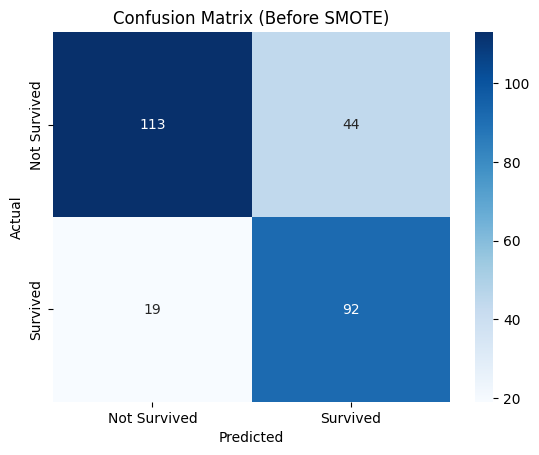

In [ ]:
conf_matrix_default = confusion_matrix(y_test, y_pred_default)
sns.heatmap(conf_matrix_default, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Before SMOTE)')
plt.show()

Untuk confussion matrix sebelum smote ditemukan bahwa angka False Negativesnya (FN) lebih banyak dibandingkan False Positives (FP), menandakan model masih kesusahan mengidentifikasi survivors daripada mengindentifikasi non-survivors

In [ ]:
cv_scores_default = cross_val_score(nb_model_default, X_train, y_train, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores (Before SMOTE): {cv_scores_default}")
print(f"Mean Cross-Validation Accuracy (Before SMOTE): {cv_scores_default.mean()}")

Cross-Validation Accuracy Scores (Before SMOTE): [0.376      0.84       0.376      0.74193548 0.72580645]
Mean Cross-Validation Accuracy (Before SMOTE): 0.6119483870967741


In [ ]:
print("=== CLASSIFICATION REPORT (BEFORE SMOTE) ===")
print(classification_report(y_test, y_pred_default, target_names=['Not Survived', 'Survived']))

=== CLASSIFICATION REPORT (BEFORE SMOTE) ===
              precision    recall  f1-score   support

Not Survived       0.86      0.72      0.78       157
    Survived       0.68      0.83      0.74       111

    accuracy                           0.76       268
   macro avg       0.77      0.77      0.76       268
weighted avg       0.78      0.76      0.77       268



<h1> Applying SMOTE for Handling Imbalance Data

Untuk mengatasi masalah class imbalance, kita menggunakan SMOTE (Synthetic Minority Over-sampling Technique).

- Objective: SMOTE menyeimbangkan distribusi kelas dengan cara membuat sampel sintetis baru untuk kelas minoritas (Survived). Berbeda dengan oversampling biasa yang hanya menduplikasi data, SMOTE membuat data baru berdasarkan "tetangga" terdekat dari sampel minoritas, sehingga menghasilkan dataset yang lebih kaya dan beragam.

- Implement: Penting untuk dicatat bahwa SMOTE hanya diterapkan pada training data (X_train, y_train). Test data (X_test) tetap dibiarkan seperti aslinya untuk memastikan evaluasi model mencerminkan performa pada data dunia nyata yang tidak seimbang.

In [ ]:
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train, y_train)

In [ ]:
nb_model_smote = GaussianNB()
nb_model_smote.fit(X_train_smote, y_train_smote)
y_pred_smote = nb_model_smote.predict(X_test)
y_pred_proba_smote = nb_model_smote.predict_proba(X_test)[:, 1]

<h1> GaussianNB (After applying SMOTE)

Model GaussianNB yang baru sekarang dilatih menggunakan data X_train_smote yang telah diseimbangkan.

- Evaluasi: Setelah dilatih pada data yang seimbang, model menunjukkan peningkatan signifikan pada Recall (dari 0.83 menjadi 0.89). Ini berarti model sekarang jauh lebih baik dalam mengidentifikasi penumpang yang selamat. Namun, Precision sedikit menurun, yang merupakan trade-off yang wajar. F1-Score secara keseluruhan sedikit meningkat, menunjukkan keseimbangan yang lebih baik.

- Confusion Matrix: Confusion matrix setelah SMOTE mengkonfirmasi bahwa jumlah False Negative menurun drastis, meskipun False Positive sedikit meningkat.

In [ ]:
accuracy_smote = accuracy_score(y_test, y_pred_smote)
precision_smote = precision_score(y_test, y_pred_smote)
recall_smote = recall_score(y_test, y_pred_smote)
f1_smote = f1_score(y_test, y_pred_smote)
roc_auc_smote = roc_auc_score(y_test, y_pred_proba_smote)

print("\n=== AFTER SMOTE ===")
print(f"Accuracy: {accuracy_smote}")
print(f"Precision: {precision_smote}")
print(f"Recall: {recall_smote}")
print(f"F1-Score: {f1_smote}")
print(f"ROC-AUC Score: {roc_auc_smote}")


=== AFTER SMOTE ===
Accuracy: 0.7425373134328358
Precision: 0.6346153846153846
Recall: 0.8918918918918919
F1-Score: 0.7415730337078652
ROC-AUC Score: 0.8259310265679692


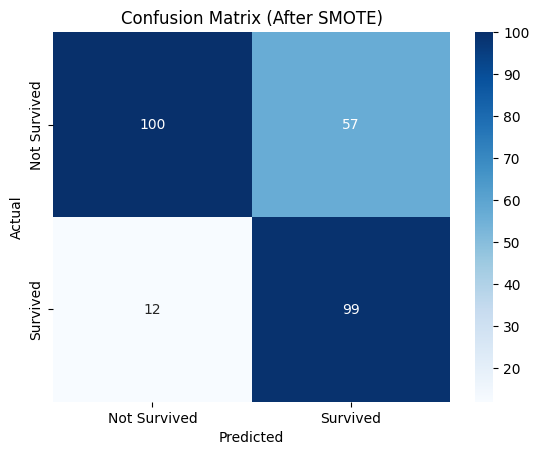

In [ ]:
conf_matrix_smote = confusion_matrix(y_test, y_pred_smote)
sns.heatmap(conf_matrix_smote, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (After SMOTE)')
plt.show()

Setelah menggunakan smote, angka False Negatives (FN) menurun 7 angka, menandakan model sudah lebih baik dalam identifikasi survivors.
Tapi angka False Positivesnya (FP) naik 13, menandakan modelnya sekarang kesusahan memprediksi survival dari non-survivor.

In [ ]:
cv_scores_smote = cross_val_score(nb_model_smote, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores (After SMOTE): {cv_scores_smote}")
print(f"Mean Cross-Validation Accuracy (After SMOTE): {cv_scores_smote.mean()}")

Cross-Validation Accuracy Scores (After SMOTE): [0.52866242 0.53503185 0.79617834 0.79617834 0.77564103]
Mean Cross-Validation Accuracy (After SMOTE): 0.6863383962110077


In [ ]:
print("\n=== CLASSIFICATION REPORT (AFTER SMOTE) ===")
print(classification_report(y_test, y_pred_smote, target_names=['Not Survived', 'Survived']))


=== CLASSIFICATION REPORT (AFTER SMOTE) ===
              precision    recall  f1-score   support

Not Survived       0.89      0.64      0.74       157
    Survived       0.63      0.89      0.74       111

    accuracy                           0.74       268
   macro avg       0.76      0.76      0.74       268
weighted avg       0.79      0.74      0.74       268



<h1> GaussianNB applying SMOTE and Hyperparameter Tuning

Langkah terakhir adalah mengoptimalkan model GaussianNB yang telah dilatih dengan data SMOTE menggunakan GridSearchCV.

- Hyperparameter Tuning: Kita melakukan tuning pada parameter var_smoothing, yaitu sebagian kecil dari varians fitur terbesar yang ditambahkan ke varians untuk stabilitas perhitungan. GridSearchCV akan menguji semua nilai yang ada di param_grid untuk menemukan nilai var_smoothing yang memberikan accuracy terbaik.

- Evaluasi Akhir: Model dengan hyperparameter terbaik kemudian dievaluasi. Hasilnya menunjukkan sedikit perbaikan lagi pada metrik F1-Score dan ROC-AUC score.

In [ ]:
param_grid = {'var_smoothing': [1e-9, 1e-8, 1e-7, 1e-6, 1e-5]}
grid_search = GridSearchCV(estimator=GaussianNB(), param_grid=param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_smote, y_train_smote)

GridSearchCV(cv=5, estimator=GaussianNB(),
             param_grid={'var_smoothing': [1e-09, 1e-08, 1e-07, 1e-06, 1e-05]},
             scoring='accuracy')

In [ ]:
best_nb_model = grid_search.best_estimator_
print(f"\nBest Parameters: {grid_search.best_params_}")
y_pred_tuned = best_nb_model.predict(X_test)
y_pred_proba_tuned = best_nb_model.predict_proba(X_test)[:, 1]


Best Parameters: {'var_smoothing': 1e-05}


In [ ]:
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
precision_tuned = precision_score(y_test, y_pred_tuned)
recall_tuned = recall_score(y_test, y_pred_tuned)
f1_tuned = f1_score(y_test, y_pred_tuned)
roc_auc_tuned = roc_auc_score(y_test, y_pred_proba_tuned)

print("\n=== AFTER SMOTE AND TUNING ===")
print(f"Accuracy: {accuracy_tuned}")
print(f"Precision: {precision_tuned}")
print(f"Recall: {recall_tuned}")
print(f"F1-Score: {f1_tuned}")
print(f"ROC-AUC Score: {roc_auc_tuned}")


=== AFTER SMOTE AND TUNING ===
Accuracy: 0.746268656716418
Precision: 0.6387096774193548
Recall: 0.8918918918918919
F1-Score: 0.7443609022556391
ROC-AUC Score: 0.8262753199058932


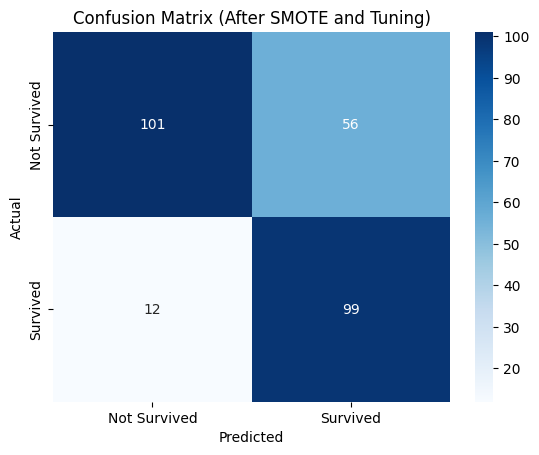

In [ ]:
conf_matrix_tuned = confusion_matrix(y_test, y_pred_tuned)
sns.heatmap(conf_matrix_tuned, annot=True, fmt='d', cmap='Blues', xticklabels=['Not Survived', 'Survived'], yticklabels=['Not Survived', 'Survived'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (After SMOTE and Tuning)')
plt.show()

Setelah di tuning, model sedikit better pada bagian False Positivenya (FP) yang hanya turun 1, dan True Negatives (TN) nya naik 1

In [ ]:
cv_scores_tuned = cross_val_score(best_nb_model, X_train_smote, y_train_smote, cv=5, scoring='accuracy')
print(f"Cross-Validation Accuracy Scores (After SMOTE and Tuning): {cv_scores_tuned}")
print(f"Mean Cross-Validation Accuracy (After SMOTE and Tuning): {cv_scores_tuned.mean()}")

Cross-Validation Accuracy Scores (After SMOTE and Tuning): [0.70063694 0.71974522 0.78980892 0.78980892 0.77564103]
Mean Cross-Validation Accuracy (After SMOTE and Tuning): 0.7551282051282051


In [ ]:
print("\n=== CLASSIFICATION REPORT (AFTER SMOTE AND TUNING) ===")
print(classification_report(y_test, y_pred_tuned, target_names=['Not Survived', 'Survived']))


=== CLASSIFICATION REPORT (AFTER SMOTE AND TUNING) ===
              precision    recall  f1-score   support

Not Survived       0.89      0.64      0.75       157
    Survived       0.64      0.89      0.74       111

    accuracy                           0.75       268
   macro avg       0.77      0.77      0.75       268
weighted avg       0.79      0.75      0.75       268



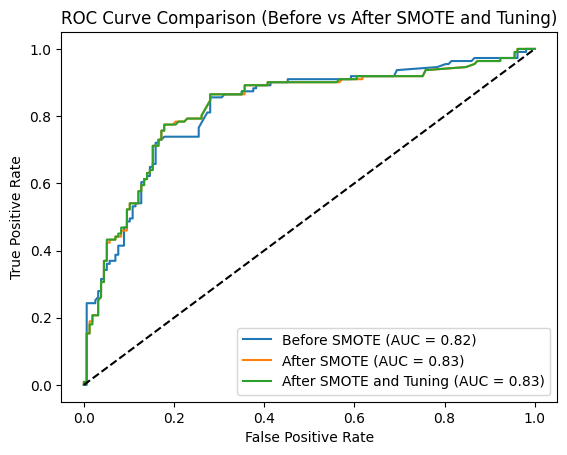

In [ ]:
fpr_default, tpr_default, _ = roc_curve(y_test, y_pred_proba_default)
fpr_smote, tpr_smote, _ = roc_curve(y_test, y_pred_proba_smote)
fpr_tuned, tpr_tuned, _ = roc_curve(y_test, y_pred_proba_tuned)

plt.plot(fpr_default, tpr_default, label='Before SMOTE (AUC = %0.2f)' % roc_auc_default)
plt.plot(fpr_smote, tpr_smote, label='After SMOTE (AUC = %0.2f)' % roc_auc_smote)
plt.plot(fpr_tuned, tpr_tuned, label='After SMOTE and Tuning (AUC = %0.2f)' % roc_auc_tuned)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison (Before vs After SMOTE and Tuning)')
plt.legend(loc="lower right")
plt.show()


<h1>Conclusion <h1>

Kurva ROC: Kurva ini memplot True Positive Rate vs. False Positive Rate. Semakin kurva mendekati pojok kiri atas, semakin baik performa model.

Kesimpulan: Dari grafik, terlihat jelas bahwa AUC (Area Under Curve) meningkat setelah penerapan SMOTE dan tuning. Ini mengkonfirmasi bahwa penanganan class imbalance dengan SMOTE dan optimasi hyperparameter berhasil meningkatkan kemampuan model Gaussian Naive Bayes dalam membedakan antara penumpang yang selamat dan tidak selamat.